<a href="https://colab.research.google.com/github/chaalp/repo/blob/master/DataVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Load chartevents data
d1 = files.upload()
chartevents = pd.read_csv('CHARTEVENTS.csv', low_memory=False)

Saving CHARTEVENTS.csv to CHARTEVENTS (1).csv


<ipython-input-4-8bc6ff24d7ff>:3: DtypeWarning: Columns (8,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  chartevents = pd.read_csv('CHARTEVENTS.csv')


In [7]:
# Load d_items data
d2 = files.upload()
d_items = pd.read_csv('D_ITEMS.csv')

Saving D_ITEMS.csv to D_ITEMS (2).csv


In [11]:
# Load procedureevents_mv data
d3 = files.upload()
procedureevents_mv = pd.read_csv('PROCEDUREEVENTS_MV.csv')

Saving PROCEDUREEVENTS_MV.csv to PROCEDUREEVENTS_MV.csv


In [14]:
# Load caregivers data
d4 = files.upload()
caregivers = pd.read_csv('CAREGIVERS.csv')

Saving CAREGIVERS.csv to CAREGIVERS.csv


In [22]:
# Load d_labitems data
d5 = files.upload()
d_labitems = pd.read_csv('D_LABITEMS.csv')

Saving D_LABITEMS.csv to D_LABITEMS.csv


In [24]:
# Load labevents data
d6 = files.upload()
labevents = pd.read_csv('LABEVENTS.csv')

Saving LABEVENTS.csv to LABEVENTS (1).csv


## Vital Signs Over Time for Subject

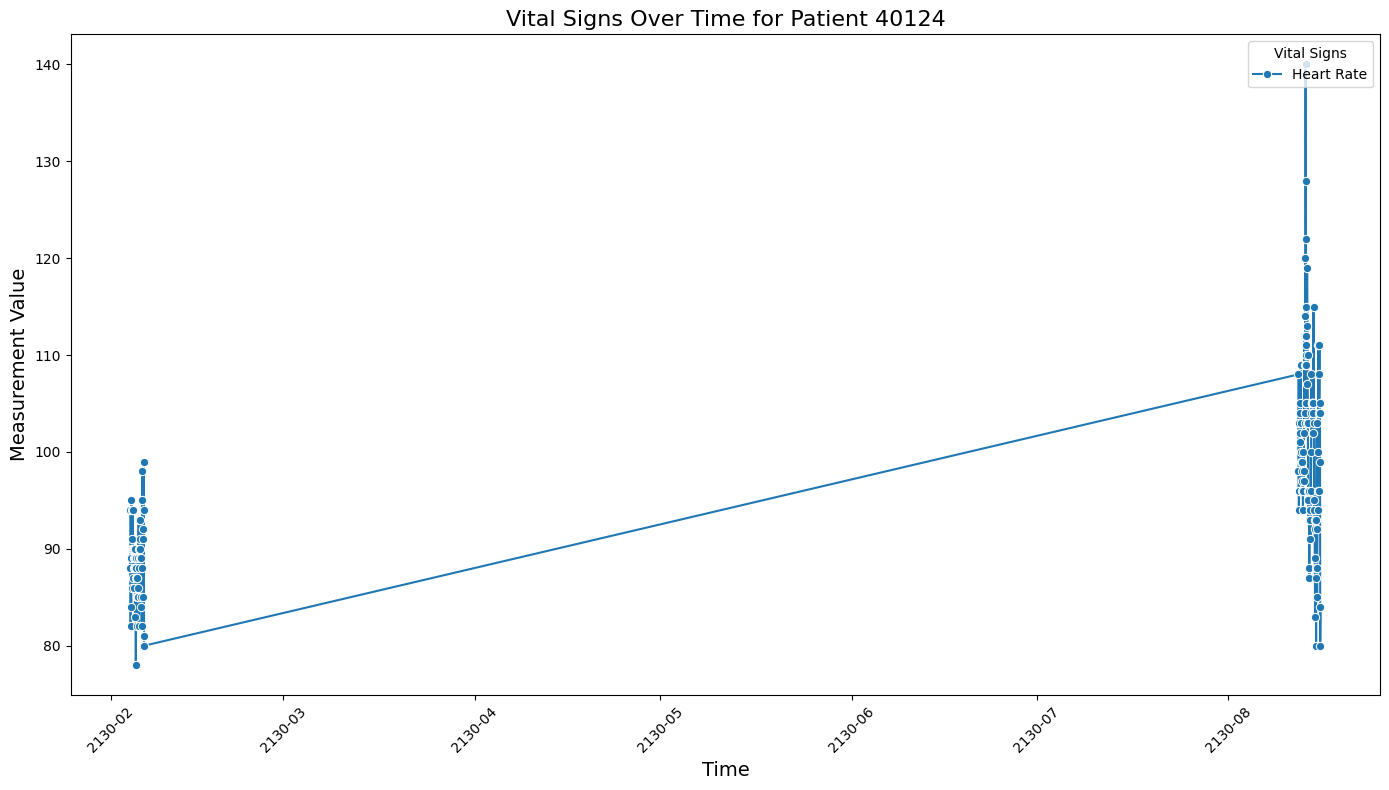

In [9]:
subject_id = 40124  # Replace with a valid subject_id from the dataset

# List of vital signs to track (ensure these are in the 'label' column of d_items)
vital_signs = ['Heart Rate']

# Get itemids corresponding to the vital signs
vital_signs_ids = d_items[d_items['label'].isin(vital_signs)][['itemid', 'label']]

# Merge with chartevents to get the data for the vital signs
vital_signs_data = pd.merge(chartevents, vital_signs_ids, on='itemid', how='inner')

# Filter data for a specific patient (subject_id)
patient_data = vital_signs_data[vital_signs_data['subject_id'] == subject_id].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Convert 'charttime' to datetime format
patient_data['charttime'] = pd.to_datetime(patient_data['charttime'], errors='coerce')

# Drop rows where 'charttime' or 'valuenum' is NaN after conversion
patient_data = patient_data.dropna(subset=['charttime', 'valuenum'])

# Set the figure size
plt.figure(figsize=(14, 8))

# Plot each vital sign over time
sns.lineplot(data=patient_data, x='charttime', y='valuenum', hue='label', palette='tab10', marker='o')

# Customize the plot
plt.title(f'Vital Signs Over Time for Patient {subject_id}', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Measurement Value', fontsize=14)
plt.legend(title='Vital Signs', loc='upper right')
plt.xticks(rotation=45)

# Show the plot with tight layout for better spacing
plt.tight_layout()
plt.show()


## Procedure/Event Frequencies Over Time

Missing values in 'starttime': 0


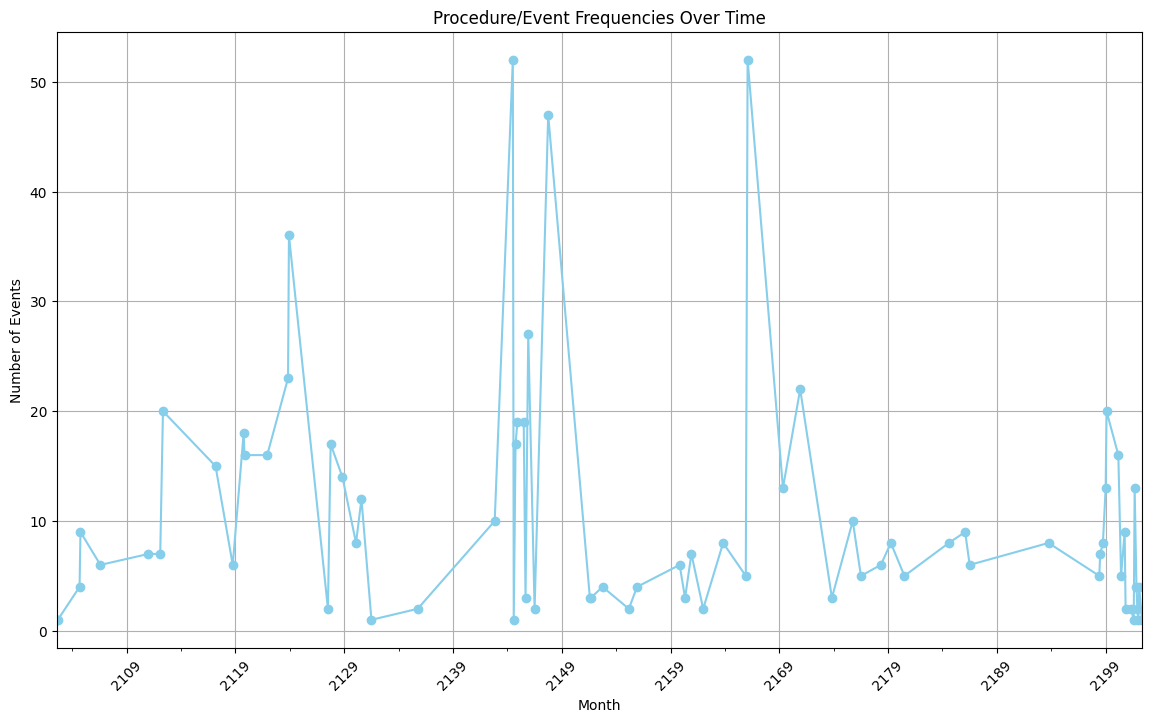

In [13]:
# Ensure 'starttime' is a datetime column
procedureevents_mv['starttime'] = pd.to_datetime(procedureevents_mv['starttime'], errors='coerce')

# Check for any missing values in the 'starttime' column after conversion
print(f"Missing values in 'starttime': {procedureevents_mv['starttime'].isnull().sum()}")

# Extract year-month from the start time
procedureevents_mv['month'] = procedureevents_mv['starttime'].dt.to_period('M')

# Count the frequency of procedures per month
event_counts = procedureevents_mv.groupby('month').size()

# Plotting the number of events per month
plt.figure(figsize=(14, 8))
event_counts.plot(kind='line', marker='o', color='skyblue')
plt.title('Procedure/Event Frequencies Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


## Number of Procedures Performed by Each Caregiver

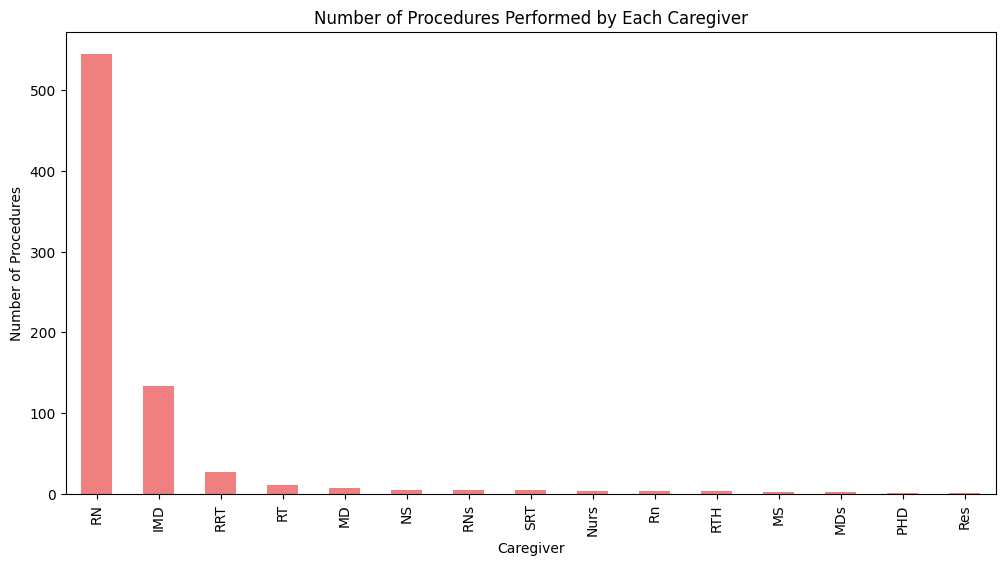

In [15]:
# Merge with procedures dataset to get caregiver data for each procedure
procedures_df = pd.merge(procedureevents_mv, caregivers, left_on='cgid', right_on='cgid', how='left')

# Count the number of procedures for each caregiver
caregiver_counts = procedures_df['label'].value_counts()

# Plotting
plt.figure(figsize=(12, 6))
caregiver_counts.plot(kind='bar', color='lightcoral')
plt.title('Number of Procedures Performed by Each Caregiver')
plt.xlabel('Caregiver')
plt.ylabel('Number of Procedures')
plt.xticks(rotation=90)
plt.show()

## Distribution of Procedure/Event Durations by Label

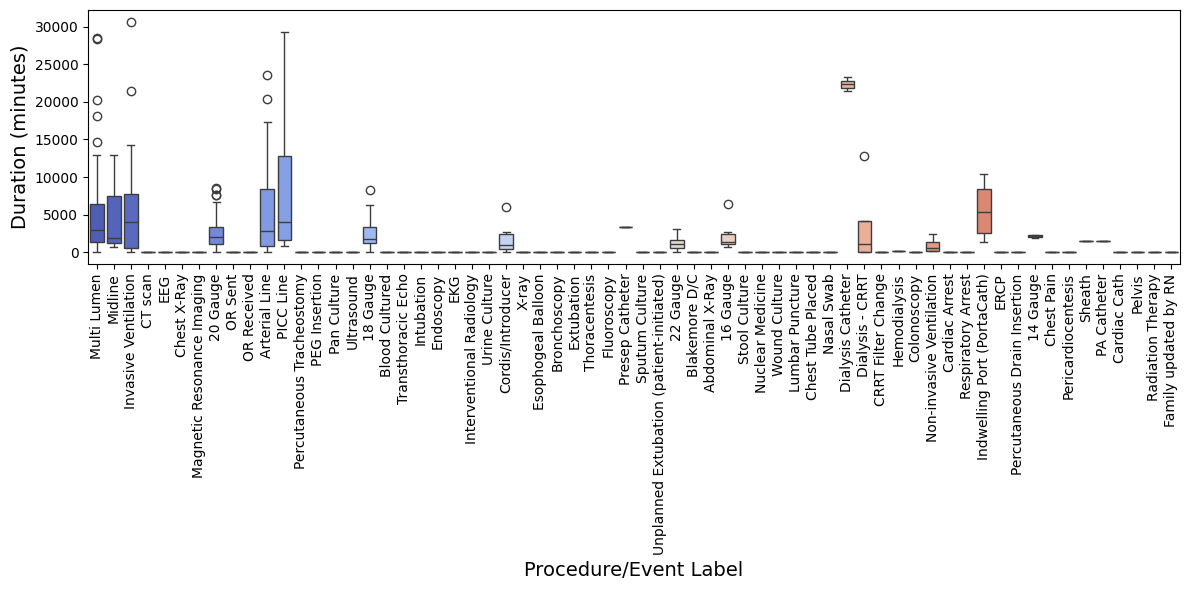

In [21]:
# Merge the two dataframes on itemid
merged_df = pd.merge(procedureevents_mv, d_items[['itemid', 'label']], on='itemid', how='left')

merged_df['starttime'] = pd.to_datetime(merged_df['starttime'])
merged_df['endtime'] = pd.to_datetime(merged_df['endtime'])

# Calculate the duration
merged_df['duration'] = (merged_df['endtime'] - merged_df['starttime']).dt.total_seconds() / 60  # Duration in minutes

# Drop rows with NaN values in 'duration' if necessary
merged_df = merged_df.dropna(subset=['duration'])

# Plot the boxplot with the correct usage of 'hue'
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='duration', data=merged_df, hue='label', palette='coolwarm', legend=False)

# Customize the plot
plt.xticks(rotation=90)  # Rotate labels for readability
plt.xlabel('Procedure/Event Label', fontsize=14)
plt.ylabel('Duration (minutes)', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

##Time series plots

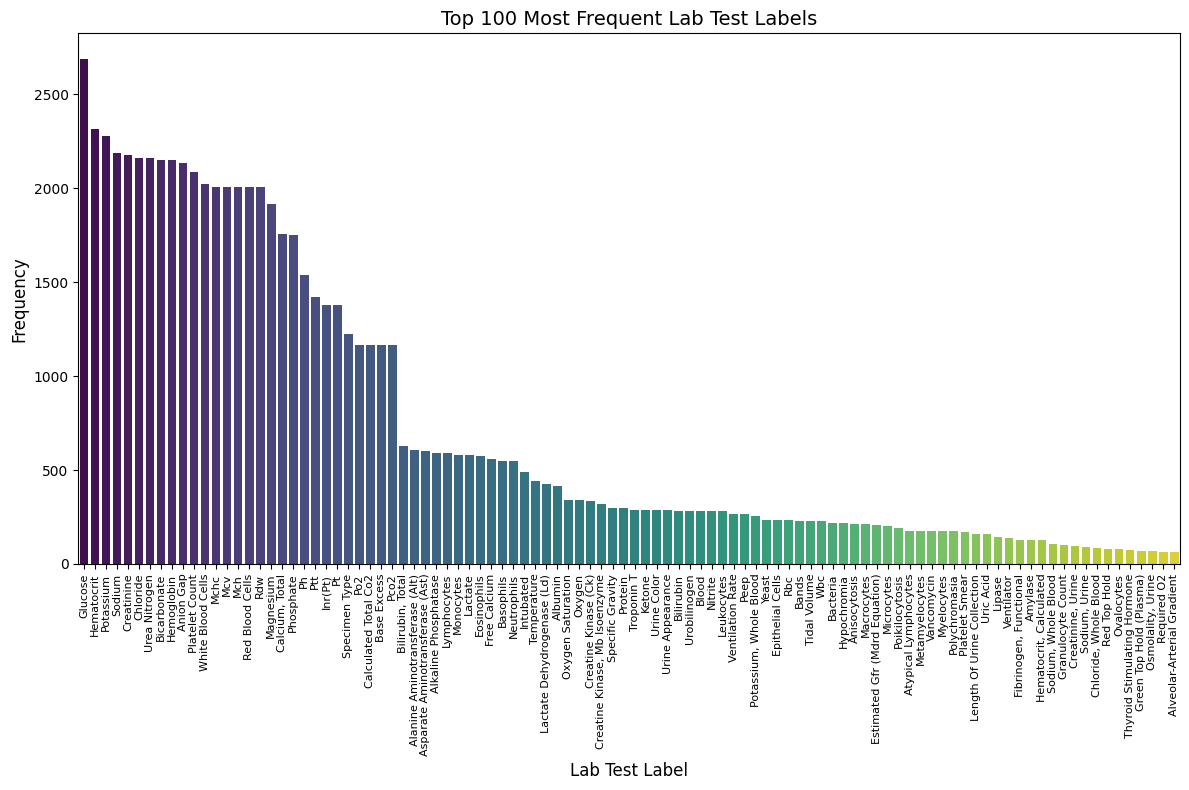

In [26]:
# Merge datasets on 'itemid'
merged_data = pd.merge(labevents, d_labitems, on='itemid', how='inner')

# Drop NaN values in 'label' to avoid issues with empty labels
merged_data = merged_data.dropna(subset=['label'])

# Get top 100 most frequent lab test labels
top_100_labels = merged_data['label'].str.title().value_counts().head(100)

# Plot: Top 100 most frequent labels
plt.figure(figsize=(12, 8))
sns.barplot(x=top_100_labels.index, y=top_100_labels.values, palette='viridis', hue=top_100_labels.index, legend=False)

# Adjust font size for the x and y axis labels
plt.xticks(rotation=90, fontsize=8)  # Smaller font size for x-axis labels
plt.yticks(fontsize=10)  # Slightly larger font size for y-axis labels

# Add title and labels
plt.title('Top 100 Most Frequent Lab Test Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Lab Test Label', fontsize=12)

# Tight layout to ensure everything fits
plt.tight_layout()

# Show plot
plt.show()